In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


**Importing the Libraries**

In [ ]:
import os
import random
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

**Loading the Files**

In [ ]:
Dalle="/content/drive/MyDrive/Deep Fake/Dataset/DM/Dalle/1_fake"
Glide="/content/drive/MyDrive/Deep Fake/Dataset/DM/glide_100_10/1_fake"
LDM="/content/drive/MyDrive/Deep Fake/Dataset/DM/ldm_100/1_fake"
Dalle_lis=os.listdir(Dalle)
Glide_lis=os.listdir(Glide)
LDM_lis=os.listdir(LDM)


In [ ]:
print(len(Dalle_lis))
print(len(Glide_lis))
print(len(LDM_lis))

1000
1000
1001


**Creating the Dataset**

In [ ]:
Dalle_dataset=[]
Glide_dataset=[]
LDM_dataset=[]

for i in range(len(Dalle_lis)):
   Dalle_lis[i]=Dalle+'/'+Dalle_lis[i]
   Dalle_dataset.append([Dalle_lis[i],1])

for i in range(len(Glide_lis)):
   Glide_lis[i]=Glide+'/'+Glide_lis[i]
   Glide_dataset.append([Glide_lis[i],2])

for i in range(len(LDM_lis)):
   LDM_lis[i]=LDM+'/'+LDM_lis[i]
   LDM_dataset.append([LDM_lis[i],3])

In [ ]:
print(len(Dalle_dataset))
print(len(Glide_dataset))
print(len(LDM_dataset))

1000
1000
1001


**Shuffling the Dataset**

In [ ]:
random.shuffle(Glide_dataset)
random.shuffle(Dalle_dataset)
random.shuffle(LDM_dataset)

In [ ]:
dataset = Glide_dataset[:1000] + LDM_dataset[:1000] + Dalle_dataset[:1000]

In [ ]:
random.shuffle(dataset)

In [ ]:
print(dataset[2])

['/content/drive/MyDrive/Deep Fake/Dataset/DM/Dalle/1_fake/kyrjicorfj.png', 1]


In [ ]:
X_train=[]
y_train=[]
for x in dataset:
    X_train.append(x[0])
    y_train.append(x[1])

**Creating Training, Validation and Testing dataset**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

**Preprocessing the data**

In [ ]:
def resize_image_3d(image_array, target_shape=(224, 224, 3)):
    if len(image_array.shape) != 3 or image_array.shape[2] != target_shape[2]:
        raise ValueError(f"Input array must have shape (height, width, {target_shape[2]})")

    resized_image = np.array(Image.fromarray(image_array).resize((target_shape[1], target_shape[0])))

    return resized_image


In [ ]:
Im_train = []
Y_train = []

for i in range(len(X_train)):
    img = Image.open(X_train[i])
    im_array = np.array(img)
    if len(im_array.shape) != 3:
        continue
    else:
        im_array = resize_image_3d(im_array)
        Im_train.append(im_array)
        Y_train.append(y_train[i])

Im_valid = []
Y_val = []

for i in range(len(X_val)):
    img = Image.open(X_val[i])
    im_array = np.array(img)
    if len(im_array.shape) != 3:
        continue
    else:
        im_array = resize_image_3d(im_array)
        Im_valid.append(im_array)
        Y_val.append(y_val[i])


Defing the parameters and hypermeters

In [ ]:
num_classes = 3
batch_size = 30
epochs = 10
learning_rate = 0.0005

Loading the base model**(Resnet50)**

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 [==============================] - 3s 0us/step


Freezing the layers of base model

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

Adding the layes

In [ ]:
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(num_classes, activation='softmax'))

Compiling the model

In [ ]:
sgd_optimizer = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

model.compile(
    optimizer=sgd_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
Im_train = np.array(Im_train)
Y_train = np.array(Y_train)
Im_valid = np.array(Im_valid)
Y_val = np.array(Y_val)



**Encoding the outputs using One Hot Encoding**

In [ ]:
encoder = OneHotEncoder(sparse=False)
Y_train_encoded = encoder.fit_transform(Y_train.reshape(-1, 1))
Y_val_encoded = encoder.transform(Y_val.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
print("Encoder categories:", encoder.categories_)
label=np.array([1,2,3])
print(encoder.transform(label.reshape(-1, 1)))

Encoder categories: [array([1, 2, 3])]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


**Training the model**

In [ ]:
history = model.fit(
    Im_train, Y_train_encoded,
    epochs=epochs,
    validation_data=(Im_valid, Y_val_encoded)
)

Epoch 1/10
75/75 [==============================] - 600s 8s/step - loss: 0.9953 - accuracy: 0.5354 - val_loss: 0.6795 - val_accuracy: 0.7067
Epoch 2/10
75/75 [==============================] - 600s 8s/step - loss: 0.5640 - accuracy: 0.7667 - val_loss: 0.5445 - val_accuracy: 0.7900
Epoch 3/10
75/75 [==============================] - 613s 8s/step - loss: 0.4583 - accuracy: 0.8208 - val_loss: 0.4941 - val_accuracy: 0.8167
Epoch 4/10
75/75 [==============================] - 593s 8s/step - loss: 0.4081 - accuracy: 0.8462 - val_loss: 0.4749 - val_accuracy: 0.8267
Epoch 5/10
75/75 [==============================] - 601s 8s/step - loss: 0.3669 - accuracy: 0.8629 - val_loss: 0.4421 - val_accuracy: 0.8433
Epoch 6/10
75/75 [==============================] - 600s 8s/step - loss: 0.3396 - accuracy: 0.8833 - val_loss: 0.4126 - val_accuracy: 0.8533
Epoch 7/10
75/75 [==============================] - 600s 8s/step - loss: 0.3128 - accuracy: 0.8950 - val_loss: 0.3983 - val_accuracy: 0.8667
Epoch 8/10
75

Learing Curves

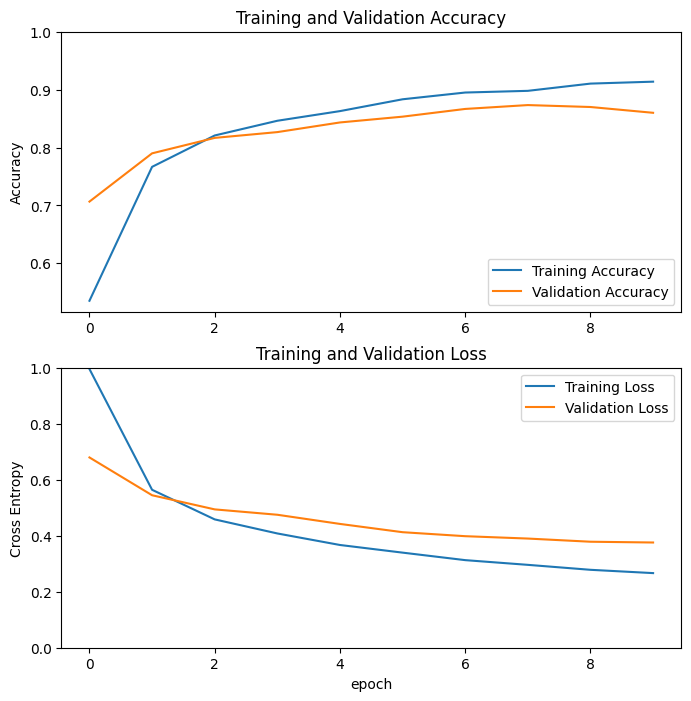

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine Tuning the Model

Unfreezing the last layers

In [ ]:
for layer in model.layers:
    layer.trainable = True

for layer in model.layers[:40]:
  layer.trainable = False

Recompile the model

In [ ]:
sgd_optimizer = optimizers.SGD(learning_rate=learning_rate/10, momentum=0.9)

model.compile(
    optimizer=sgd_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Training the Model**

In [ ]:
history_fine = model.fit(
    Im_train, Y_train_encoded,
    epochs=15,
    initial_epoch=history.epoch[-1],
    validation_data=(Im_valid, Y_val_encoded)
)

Epoch 10/15
75/75 [==============================] - 630s 8s/step - loss: 0.2536 - accuracy: 0.9200 - val_loss: 0.3758 - val_accuracy: 0.8600
Epoch 11/15
75/75 [==============================] - 589s 8s/step - loss: 0.2536 - accuracy: 0.9200 - val_loss: 0.3758 - val_accuracy: 0.8600
Epoch 12/15
75/75 [==============================] - 572s 8s/step - loss: 0.2536 - accuracy: 0.9200 - val_loss: 0.3758 - val_accuracy: 0.8600
Epoch 13/15
75/75 [==============================] - 591s 8s/step - loss: 0.2536 - accuracy: 0.9200 - val_loss: 0.3758 - val_accuracy: 0.8600
Epoch 14/15
75/75 [==============================] - 592s 8s/step - loss: 0.2536 - accuracy: 0.9200 - val_loss: 0.3758 - val_accuracy: 0.8600
Epoch 15/15
75/75 [==============================] - 572s 8s/step - loss: 0.2536 - accuracy: 0.9200 - val_loss: 0.3758 - val_accuracy: 0.8600


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

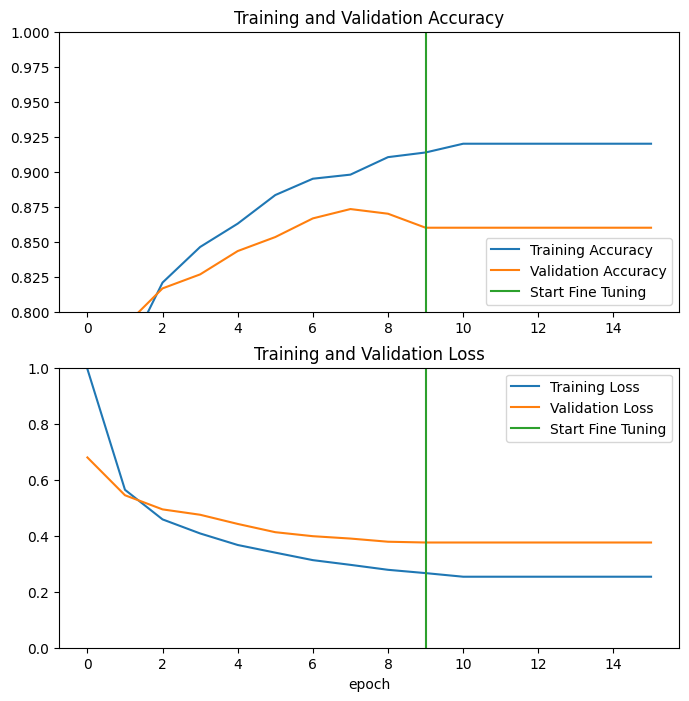

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([9,9],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([9,9],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Testing the Model**

In [38]:
Im_test = []
Y_test = []

for i in range(len(X_test)):
    img = Image.open(X_test[i])
    im_array = np.array(img)
    if len(im_array.shape) != 3:
        continue
    else:
        im_array = resize_image_3d(im_array)
        Im_test.append(im_array)
        Y_test.append(y_test[i])

In [39]:
Im_test = np.array(Im_test)
Y_test = np.array(Y_test)

In [40]:
Y_test_encoded = encoder.transform(Y_test.reshape(-1, 1))

Evaluating the model

In [41]:
evaluation = model.evaluate(Im_test, Y_test_encoded)

10/10 [==============================] - 71s 7s/step - loss: 0.4027 - accuracy: 0.8500


In [42]:
accuracy = evaluation[1]

print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.8500000238418579
